This notebooks documents the process of generating Author visualizations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
# matplotlib.rcParams['figure.dpi']= 200
import altair as alt
pd.set_option('display.max_rows', 500)
import numpy as np
import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from altair_saver import save

In [2]:
author = pd.read_csv('../data/ht_class/ht_cleaned_author_df.csv')
paper = pd.read_csv('../data/ht_class/ht_cleaned_paper_df.csv')

In [3]:
total_authors = author.shape[0]
total_authors

12428

### Number of participating countries by year

In [4]:
cntry_num_by_year = author.groupby('Year')[
    'Affiliation Country Code'].nunique().reset_index(
    name='Number of participating countries')
# cntry_num_by_year.rename(columns = {'Year': 'year'}, inplace = True)
cntry_num_by_year['Year'] = pd.to_datetime(
    cntry_num_by_year['Year'], format='%Y')
cntry_num_by_year.head()

,Year,Number of participating countries
0,1990-01-01,5
1,1991-01-01,8
2,1992-01-01,11
3,1993-01-01,12
4,1994-01-01,9


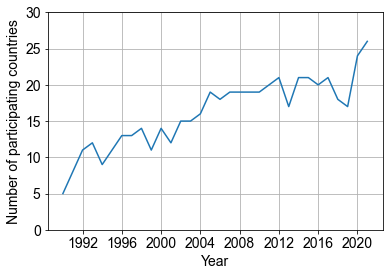

In [5]:
g = sns.lineplot(x = 'Year', 
             y = 'Number of participating countries', 
             data = cntry_num_by_year
            )
g.set_ylim(0,30)
plt.grid()

In [6]:
source = cntry_num_by_year

alt.Chart(source).mark_line().encode(
    x='Year:T',
    y=alt.Y(
        'Number of participating countries',
    )
).properties(
    title = 'A'
).configure_title(
    anchor='start',  
)

alt.Chart(...)

### By continent

In [7]:
from pycountry_convert import country_alpha2_to_continent_code
import pycountry

In [8]:
dic = dict(Counter(author['Affiliation Country Code']))
continent_df = pd.DataFrame(dic.items(), columns = ['code', 'count'])
continent_df['continent'] = continent_df['code'].apply(
    lambda x: country_alpha2_to_continent_code(x))
continent_df.head()

,code,count,continent
0,US,6576,NA
1,NL,308,EU
2,DE,1656,EU
3,CH,161,EU
4,IL,72,AS


In [9]:
continent_count = continent_df.groupby(
    'continent')['count'].sum().reset_index()
continent_count['proportion'] = round(
    continent_count['count'] / continent_count['count'].sum(),
    3
)
continent_count.replace({'AF': 'Africa',
                         'AS': 'Asia',
                         'EU': 'Europe',
                         'NA': 'N. America',
                         'SA': 'S. America',
                         'OC': 'Oceania',
                        }, inplace = True)
continent_count

,continent,count,proportion
0,Africa,3,0.000
1,Asia,1383,0.111
2,Europe,3802,0.306
3,N. America,7005,0.564
4,Oceania,151,0.012
5,S. America,84,0.007


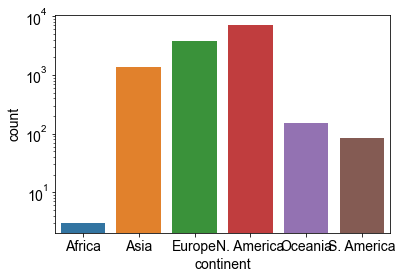

In [10]:
sns.barplot(x = 'continent', y = 'count', data = continent_count)
plt.yscale('log')

In [11]:
source = continent_count

chart = alt.Chart(source).mark_bar().encode(
    x='continent',
    y=alt.Y(
        'count',
        scale=alt.Scale(type="log")  # Here the scale is applied
    ),
    color = 'continent',
).properties(
    title = 'A'
)

chart

alt.Chart(...)

### Top countries (Stack area charts)

In [12]:
dic = dict(Counter(author['Affiliation Country Code']).most_common(5))
top_five = list(dic.keys())
df = pd.DataFrame(dic.items(), columns = ['country', 'count'])
df['ratio'] = round(df['count'] / total_authors, 3)
df

,country,count,ratio
0,US,6576,0.529
1,DE,1656,0.133
2,CN,1013,0.082
3,AT,523,0.042
4,CA,429,0.035


In [13]:
df.ratio.sum()

0.8210000000000001

In [14]:
# prepare for timeseries plot
cntry_ts_prop = []
for group in author.groupby('Year'):
    year = group[0]
    year_total = group[1].shape[0]
    group[1]['cntry new'] = group[1]['Affiliation Country Code'].apply(
        lambda x: x if x in top_five else 'Other'
    )
    for cntry_group in group[1].groupby('cntry new'):
        cntry_code = cntry_group[0]
        cntry_year_total = cntry_group[1].shape[0]
        cntry_prop = cntry_year_total / year_total
        cntry_ts_prop.append((year, cntry_code, cntry_year_total, cntry_prop))

In [15]:
cntry_ts_prop[1:10]

[(1990, 'DE', 4, 0.03361344537815126),
 (1990, 'Other', 5, 0.04201680672268908),
 (1990, 'US', 109, 0.9159663865546218),
 (1991, 'DE', 3, 0.0234375),
 (1991, 'Other', 13, 0.1015625),
 (1991, 'US', 112, 0.875),
 (1992, 'CA', 1, 0.007518796992481203),
 (1992, 'CN', 2, 0.015037593984962405),
 (1992, 'DE', 7, 0.05263157894736842)]

In [16]:
cntry_ts_prop_df = pd.DataFrame(
    list(cntry_ts_prop), columns=['year', 'country', 'year total', 'ratio']) 
cntry_ts_prop_df['Year'] = pd.to_datetime(
    cntry_ts_prop_df['year'], format='%Y')
cntry_ts_prop_df.replace({'CA': 'Canada',
                          'DE': 'Germany',
                          'CN': 'China',
                          'AT': 'Austria',
                         }, inplace = True)
cntry_ts_prop_df.head()

,year,country,year total,ratio,Year
0,1990,Canada,1,0.008403,1990-01-01
1,1990,Germany,4,0.033613,1990-01-01
2,1990,Other,5,0.042017,1990-01-01
3,1990,US,109,0.915966,1990-01-01
4,1991,Germany,3,0.023438,1991-01-01


In [17]:
list(set(cntry_ts_prop_df.country.tolist()))

['Germany', 'China', 'Canada', 'Other', 'US', 'Austria']

In [18]:
source = cntry_ts_prop_df

alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="year total:Q",
    color="country:N"
)

alt.Chart(...)

In [19]:
source = cntry_ts_prop_df

chart1 = alt.Chart(source).mark_area().encode(
    x="Year:T",
    y="year total:Q",
    color="country:N"
)

chart1

alt.Chart(...)

In [20]:
source = cntry_ts_prop_df

chart2 = alt.Chart(source).mark_area().encode(
    x="Year:T",
    y=alt.Y(
        "ratio:Q",
        title = 'Proportion'
    ),
    color=alt.Color(
        "country:N",
        title = 'Country/Region',
    )
).configure_axis(
    labelFontSize=15,
    titleFontSize=20
).configure_legend(
    titleFontSize=16,
    labelFontSize=16
).configure_title(
    anchor='start',
    fontSize=20
).properties(
    width=420
)

chart2

alt.Chart(...)

### Papers involving US authors

In [21]:
def get_total_and_ratio_by_year(DF, subgroup_par):
    tuples = []
    for group in DF.groupby('Year'):
        year = group[0]
        total = group[1].shape[0]
        for subgroup in group[1].groupby(subgroup_par):
            subtype = 'Yes' if subgroup[0] else 'No'
            count = subgroup[1].shape[0]
            ratio = count / total
            tuples.append((year, subtype, count, ratio))
    dff = pd.DataFrame(
        list(tuples), columns=['year', 'type', 'count', 'ratio']) 
    return dff

In [22]:
withus_authors = get_total_and_ratio_by_year(paper, 'With US Authors')
withus_authors.rename(columns = {
#     'year': 'Year',
    'type': 'With US Authors', 
    'ratio': 'Ratio'}, inplace=True)
withus_authors['Year'] = pd.to_datetime(withus_authors['year'], format='%Y')
withus_authors.head()

,year,With US Authors,count,Ratio,Year
0,1990,No,6,0.115385,1990-01-01
1,1990,Yes,46,0.884615,1990-01-01
2,1991,No,6,0.120000,1991-01-01
3,1991,Yes,44,0.880000,1991-01-01
4,1992,No,10,0.188679,1992-01-01


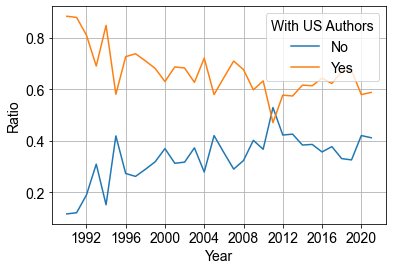

In [23]:
g = sns.lineplot(x='Year', y='Ratio', hue='With US Authors', 
                 data = withus_authors)
plt.grid()

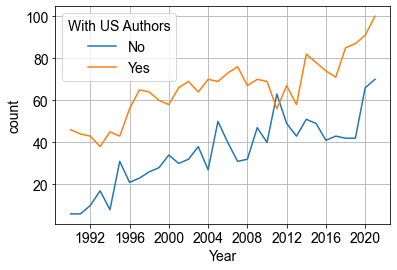

In [24]:
g = sns.lineplot(x='Year', y='count', hue='With US Authors', 
                 data = withus_authors)
plt.grid()

In [25]:
source = withus_authors

chart1 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="Ratio:Q",
    color="With US Authors:N"
).properties(
    width=300
)

chart2 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="count:Q",
    color="With US Authors:N"
).properties(
    width=300
)

alt.hconcat(chart1, chart2)

alt.HConcatChart(...)

In [26]:
source = withus_authors

chart1 = alt.Chart(source).mark_area().encode(
    x="Year:T",
    y="Ratio:Q",
    color="With US Authors:N"
).properties(
    width=300
)

chart2 = alt.Chart(source).mark_area().encode(
    x="Year:T",
    y="count:Q",
    color="With US Authors:N"
).properties(
    width=300
)

alt.hconcat(chart1, chart2)

alt.HConcatChart(...)

### Affiliation types, global

In [27]:
dic = dict(Counter(author['Affiliation Type']))
author_aff_count = pd.DataFrame(dic.items(), columns = ['type', 'count'])
author_aff_count['ratio'] = round(
    author_aff_count['count'] / author_aff_count['count'].sum(),
    3)
author_aff_count

,type,count,ratio
0,education,9583,0.771
1,company,1292,0.104
2,facility,1085,0.087
3,government,241,0.019
4,nonprofit,65,0.005
5,other,9,0.001
6,healthcare,134,0.011
7,archive,19,0.002


In [28]:
source = author_aff_count

chart = alt.Chart(source).mark_bar().encode(
    x='type',
    y=alt.Y(
        'count',
        scale=alt.Scale(type="log")  # Here the scale is applied
    ),
    color = 'type',
)

chart

alt.Chart(...)

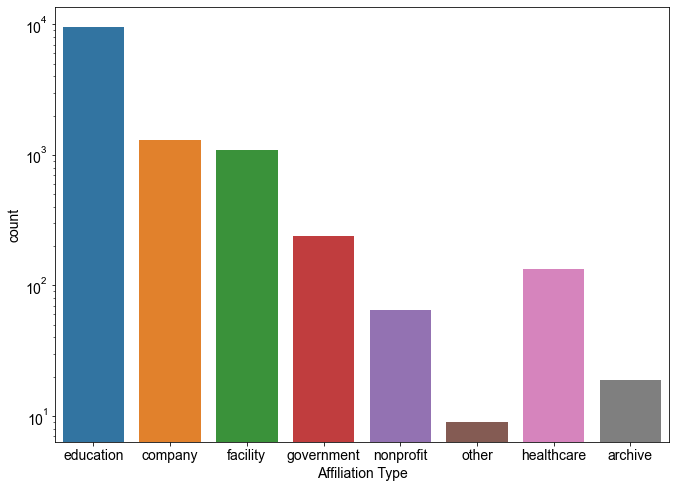

In [29]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x = 'Affiliation Type', data = author, ax = ax)
plt.yscale('log')

In [30]:
tuples = []
for group in author.groupby('Year'):
    year = group[0]
    total = group[1].shape[0]
    for subgroup in group[1].groupby('Binary Type'):
        aff_type = subgroup[0]
        count = subgroup[1].shape[0]
        ratio = count / total
        tuples.append((year, aff_type, count, ratio))

In [31]:
binary_type_df = pd.DataFrame(list(tuples), columns=['year', 'type', 'count', 'ratio']) 
binary_type_df['Year'] = pd.to_datetime(binary_type_df['year'], format='%Y')
binary_type_df.replace({
    'education': 'Education',
    'non-education': 'Non-Education'
}, inplace= True)
binary_type_df.tail(10)

,year,type,count,ratio,Year
54,2017,Education,423,0.784787,2017-01-01
55,2017,Non-Education,116,0.215213,2017-01-01
56,2018,Education,466,0.792517,2018-01-01
57,2018,Non-Education,122,0.207483,2018-01-01
58,2019,Education,566,0.834808,2019-01-01
59,2019,Non-Education,112,0.165192,2019-01-01
60,2020,Education,665,0.838588,2020-01-01
61,2020,Non-Education,128,0.161412,2020-01-01
62,2021,Education,706,0.835503,2021-01-01
63,2021,Non-Education,139,0.164497,2021-01-01


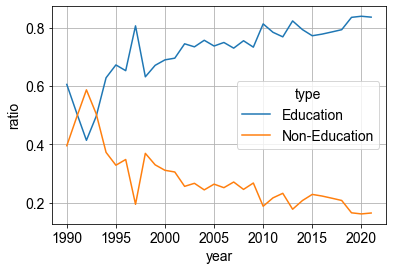

In [32]:
g = sns.lineplot(x='year', y='ratio', hue='type', data = binary_type_df)
plt.grid()

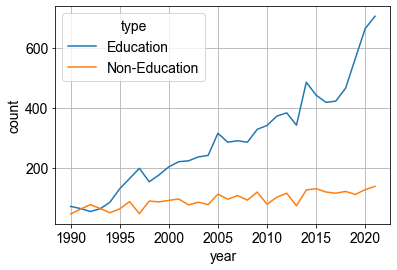

In [33]:
g = sns.lineplot(x='year', y='count', hue='type', data = binary_type_df)
plt.grid()

In [34]:
source = binary_type_df

chart1 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="count:Q",
    color="type:N"
).properties(
    height=300,
    width=300
)

chart2 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="ratio:Q",
    color="type:N"
).properties(
    height=300,
    width=250
)

alt.hconcat(chart1, chart2)

alt.HConcatChart(...)

## Affiliation type without the US

This is to answer Reviewer 3's question

In [35]:
non_us_authors = author[author['Affiliation Country Code'] != 'US'][[
    'Year', 'Binary Type']].reset_index(drop=True)
non_us_authors.head(2)

,Year,Binary Type
0,2006,education
1,2003,education


In [36]:
tuples = []
for group in non_us_authors.groupby('Year'):
    year = group[0]
    total = group[1].shape[0]
    for subgroup in group[1].groupby('Binary Type'):
        aff_type = subgroup[0]
        count = subgroup[1].shape[0]
        ratio = count / total
        tuples.append((year, aff_type, count, ratio))

In [37]:
non_us_author_df = pd.DataFrame(list(tuples), columns=['year', 'type', 'count', 'ratio']) 
non_us_author_df['Year'] = pd.to_datetime(non_us_author_df['year'], format='%Y')
non_us_author_df.replace({
    'education': 'Education (non-US)',
    'non-education': 'Non-Education (non-US)'
}, inplace= True)
non_us_author_df.tail(10)

,year,type,count,ratio,Year
54,2017,Education (non-US),267,0.878289,2017-01-01
55,2017,Non-Education (non-US),37,0.121711,2017-01-01
56,2018,Education (non-US),257,0.842623,2018-01-01
57,2018,Non-Education (non-US),48,0.157377,2018-01-01
58,2019,Education (non-US),313,0.909884,2019-01-01
59,2019,Non-Education (non-US),31,0.090116,2019-01-01
60,2020,Education (non-US),409,0.850312,2020-01-01
61,2020,Non-Education (non-US),72,0.149688,2020-01-01
62,2021,Education (non-US),432,0.890722,2021-01-01
63,2021,Non-Education (non-US),53,0.109278,2021-01-01


In [38]:
source = non_us_author_df

chart1 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="count:Q",
    color="type:N"
).properties(
    height=300,
    width=300
)

chart2 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="ratio:Q",
    color="type:N"
).properties(
    height=300,
    width=300
)

alt.hconcat(chart1, chart2)

alt.HConcatChart(...)

### Afffiliation type within the US

In [39]:
us_authors = author[author['Affiliation Country Code'] == 'US'][[
    'Year', 'Binary Type']].reset_index(drop=True)

In [40]:
tuples = []
for group in us_authors.groupby('Year'):
    year = group[0]
    total = group[1].shape[0]
    for subgroup in group[1].groupby('Binary Type'):
        aff_type = subgroup[0]
        count = subgroup[1].shape[0]
        ratio = count / total
        tuples.append((year, aff_type, count, ratio))

In [41]:
us_author_df = pd.DataFrame(list(tuples), columns=['year', 'type', 'count', 'ratio']) 
us_author_df['Year'] = pd.to_datetime(us_author_df['year'], format='%Y')
us_author_df.replace({
    'education': 'Education (US)',
    'non-education': 'Non-Education (US)'
}, inplace= True)
us_author_df.tail(10)

,year,type,count,ratio,Year
54,2017,Education (US),156,0.663830,2017-01-01
55,2017,Non-Education (US),79,0.336170,2017-01-01
56,2018,Education (US),209,0.738516,2018-01-01
57,2018,Non-Education (US),74,0.261484,2018-01-01
58,2019,Education (US),253,0.757485,2019-01-01
59,2019,Non-Education (US),81,0.242515,2019-01-01
60,2020,Education (US),256,0.820513,2020-01-01
61,2020,Non-Education (US),56,0.179487,2020-01-01
62,2021,Education (US),274,0.761111,2021-01-01
63,2021,Non-Education (US),86,0.238889,2021-01-01


In [42]:
source = us_author_df

chart1 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="count:Q",
    color="type:N"
).properties(
    height=300,
    width=300
)

chart2 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y="ratio:Q",
    color="type:N"
).properties(
    height=300,
    width=300
)

alt.hconcat(chart1, chart2)

alt.HConcatChart(...)

In [43]:
source1 = binary_type_df

chart1 = alt.Chart(source1).mark_line().encode(
    x="Year:T",
    y="ratio:Q",
    color=alt.Color("type:N",
                title = 'Affiliation types',
                    scale=alt.Scale(domain=['Education', 'Non-Education'],
                      range=['steelblue', 'orange']))
).properties(
    height=300,
    width=250
)

source2 = us_author_df

chart2 = alt.Chart(source2).mark_line().encode(
    x="Year:T",
    y="ratio:Q",
    color=alt.Color("type:N",
                    title = '',
                    scale=alt.Scale(domain=['Education (US)', 'Non-Education (US)'],
                      range=['purple', 'green']))
).properties(
    height=300,
    width=300
)

alt.layer(
    chart1,
    chart2
).resolve_scale(color='independent')

alt.LayerChart(...)

In [44]:
source1 = binary_type_df

chart1 = alt.Chart(source1).mark_line().encode(
    x="Year:T",
    y="count:Q",
    color=alt.Color("type:N",
                title = 'Affiliation types',
                    scale=alt.Scale(domain=['Education', 'Non-Education'],
                      range=['steelblue', 'orange']))
).properties(
    height=300,
    width=250
)

source2 = us_author_df

chart2 = alt.Chart(source2).mark_line().encode(
    x="Year:T",
    y="count:Q",
    color=alt.Color("type:N",
                    title = '',
                    scale=alt.Scale(domain=['Education (US)', 'Non-Education (US)'],
                      range=['purple', 'green']))
).properties(
    height=300,
    width=300
)

alt.layer(
    chart1,
    chart2
).resolve_scale(color='independent')

alt.LayerChart(...)

In [45]:
ratio_wording = 'Proportion' 
# or 'Percentage', or 'Ratio'

In [46]:
## Num of countries by year

source = cntry_num_by_year

chart1 = alt.Chart(source).mark_line().encode(
    x='Year:T',
    y=alt.Y(
        'Number of participating countries',
        title = 'Number of countries'
    )
).properties(
    title = 'a',
    width=240
)

## top countries

source = cntry_ts_prop_df

chart2 = alt.Chart(source).mark_area().encode(
    x="Year:T",
    y=alt.Y("year total:Q",title='Number of authors'),
    color=alt.Color(
        "country:N",
        title = 'Country/Region',
#         legend=alt.Legend(orient='top-left')
               )
).properties(
    title = 'b',
    width = 300,
)

## Continent
source = continent_count

chart3 = alt.Chart(source).mark_bar().encode(
    x=alt.X("continent:N",
            title='Continent',
            axis=alt.Axis(labelAngle=-40)
           ),
    y=alt.Y(
        'count',
        title = 'Number of authors',
        scale=alt.Scale(type="log")  # Here the scale is applied
    ),
    color=alt.Color(
        "continent:N",
        title = 'Continent',
        legend=None,
    )
).properties(
    title = 'c',
    width=200
)

## With US Authors
source = withus_authors

chart4 = alt.Chart(source).mark_line().encode(
    x="Year:T",
    y=alt.Y(
        "Ratio:Q",
        title = ratio_wording
    ),
    color=alt.Color(
        "With US Authors:N",
        title="With US authors",
        sort=['Yes', 'No'],
        legend=alt.Legend(
            orient='none',
            legendX=90, legendY=15,
            direction='horizontal',
            titleAnchor='middle'
    )
    )
).properties(
    title = 'd',
    width=240
)

author1 = alt.hconcat(chart1, chart2, chart3, chart4).configure_title(
    anchor='start',
    fontSize = 20
).resolve_scale(
    color='independent',
#     scheme='category10'
    
).configure_axis(
    labelFontSize=15,
    titleFontSize=20
).configure_legend(
    titleFontSize=16,
    labelFontSize=16
).configure_title(
    anchor='start',
    fontSize=22)


# .configure_axis(
#     labelFontSize=15,
#     titleFontSize=16
# ).configure_legend(
#     titleFontSize=14,
#     labelFontSize=16
# ) 

author1

alt.HConcatChart(...)

In [47]:
# ## Affiliation types
# source = author_aff_count

# chart5 = alt.Chart(source).mark_bar().encode(
#     x='type',
#     y=alt.Y(
#         'count',
#         scale=alt.Scale(type="log")  # Here the scale is applied
#     ),
#     color = 'type',
# ).properties(
#     title = 'D'
# )
# chart5

In [51]:
## Affiliation types
source1 = author_aff_count

chart1 = alt.Chart(source1).mark_bar().encode(
    x=alt.X('type',
            title = 'Author affiliation type',
            axis=alt.Axis(labelAngle=-40),
           ),
    y=alt.Y(
        'count',
        title = "Number of authors",
        scale=alt.Scale(type="log")  # Here the scale is applied
    ),
    color=alt.Color(
        "type:N",
        title = 'Affiliation type',
        legend=None,
    )
).properties(
    height=300,
    width=260,
    title = 'e'
)

source2_1 = binary_type_df

chart2_1 = alt.Chart(source2_1).mark_line().encode(
    x="Year:T",
    y=alt.Y(
        "ratio:Q",
        title = ratio_wording,
    ),
    color=alt.Color(
        "type:N",
        title = 'Affiliation type',
        scale=alt.Scale(
            domain=['Education', 'Non-Education'],
            range = ['steelblue', 'orange']
#             range = ['#4daf4a','#984ea3'],
        )))

source2_2 = us_author_df

chart2_2 = alt.Chart(source2_2).mark_line(
    point={
      "filled": False,
      "fill": "white"
    },
    strokeDash=[1,2]
).encode(
    x="Year:T",
    y=alt.Y(
        "ratio:Q",
        title = ratio_wording,
    ),
    color=alt.Color("type:N",
                    title = '',
                    scale=alt.Scale(domain=['Education (US)', 'Non-Education (US)'],
                      range=['green', 'purple']))
)

chart2 = alt.layer(
    chart2_1,
    chart2_2
).resolve_scale(color='independent').properties(
    height=300,
    width=260,
    title = 'f'
)


### 
source3_1 = binary_type_df

chart3_1 = alt.Chart(source3_1).mark_line().encode(
    x="Year:T",
    y=alt.Y(
        "count:Q",
        title = 'Number of authors',
    ),
    color=alt.Color(
        "type:N",
        title = 'Affiliation type',
        scale=alt.Scale(domain=['Education', 'Non-Education'],
        range=['steelblue', 'orange']),
#         legend=alt.Legend(orient='top-left')
    )
)

source3_2 = us_author_df

chart3_2 = alt.Chart(source3_2).mark_line(
    point={
      "filled": False,
      "fill": "white"
    },
    strokeDash=[1,2]
).encode(
    x="Year:T",
    y="count:Q",
    color=alt.Color(
        "type:N",
        title = '',
        scale=alt.Scale(
            domain=['Education (US)', 'Non-Education (US)'],
            range=['green', 'purple']),
        )
)

chart3 = alt.layer(
    chart3_1,
    chart3_2,
).resolve_scale(color='independent').properties(
    title = 'g',
    height=300,
    width=260
)

# chart_last = alt.hconcat()

author2 = alt.hconcat(chart1, chart2, chart3).configure_title(
    anchor='start',
    fontSize = 16
).resolve_scale(
    color='independent',
).configure_axis(
    labelFontSize=15,
    titleFontSize=20
).configure_legend(
    titleFontSize=16,
    labelFontSize=16
).configure_title(
    anchor='start',
    fontSize=22)

author2

alt.HConcatChart(...)